# Optimising Model Prediction

In this guided project I will start with a reference standard linear model and iterate on it using techniques suchas outlier detection, k-fold cross-validation and regularisation. The aim to to improve the model as much as possible.  
The data comes from the [Forest Fires](https://archive.ics.uci.edu/dataset/162/forest+fires) dataset from the UCI Machine Learning Repository. This dataset contains information on fires, along with the resulting damage and associated meteorological data. I will determine how these characteristics might be useful in predicting future fire damage.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

fires = pd.read_csv("data/fires.csv")
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  517 non-null    int64  
 1   X           517 non-null    int64  
 2   Y           517 non-null    int64  
 3   month       517 non-null    object 
 4   day         517 non-null    object 
 5   FFMC        469 non-null    float64
 6   DMC         496 non-null    float64
 7   DC          474 non-null    float64
 8   ISI         515 non-null    float64
 9   temp        496 non-null    float64
 10  RH          487 non-null    float64
 11  wind        482 non-null    float64
 12  rain        485 non-null    float64
 13  area        517 non-null    float64
dtypes: float64(9), int64(3), object(2)
memory usage: 56.7+ KB


The dataset has 517 rows and 14 columns. Below is the description of each column according to the orginial dataset
- `X`	Feature	Integer		x-axis spatial coordinate within the Montesinho park map: 1 to 9
- `Y`	Feature	Integer		y-axis spatial coordinate within the Montesinho park map: 2 to 9
- `month`	Feature	Categorical		month of the year: 'jan' to 'dec'
- `day`	Feature	Categorical		day of the week: 'mon' to 'sun'
- `FFMC`	Feature	Continuous		FFMC index from the FWI system: 18.7 to 96.20
- `DMC`	Feature	Integer		DMC index from the FWI system: 1.1 to 291.3
- `DC`	Feature	Continuous		DC index from the FWI system: 7.9 to 860.6
- `ISI`	Feature	Continuous		ISI index from the FWI system: 0.0 to 56.10
- `temp`	Feature	Continuous		temperature: 2.2 to 33.30	Celsius degrees
- `RH`	Feature	Integer		relative humidity: 15.0 to 100	%
- `wind`	Feature	Continuous		wind speed: 0.40 to 9.40	km/h
- `rain`	Feature	Integer		outside rain: 0.0 to 6.4	mm/m2
- `area`	Target	Integer		the burned area of the forest: 0.00 to 1090.84 (this output variable is very skewed towards 0.0, thus it may make sense to model with the logarithm transform).	ha

Many of the columns contain missing data

## Data Processing

The datasets null values will need to be processed. The two columns with string values will also need to be amended.  
But first I must examine the columns of interest to understand thier distributions.

<Axes: >

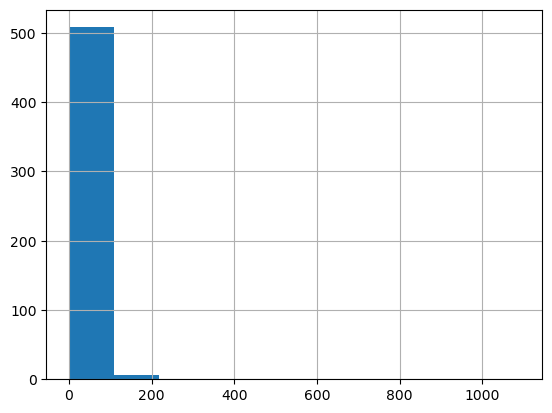

In [2]:
fires["area"].hist()

<Axes: >

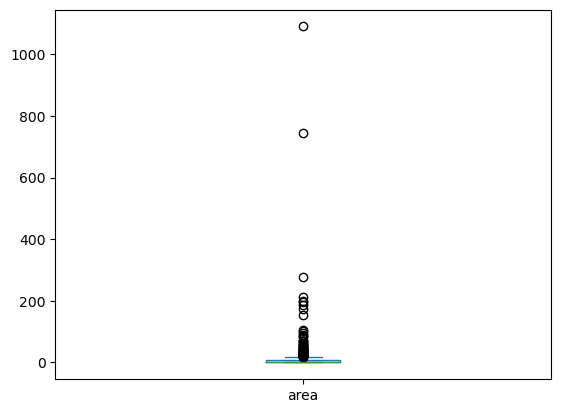

In [3]:
fires["area"].plot.box()

The target `area` is very heavily right-skewed and has some outliers. I will try using a log transformation

<Axes: >

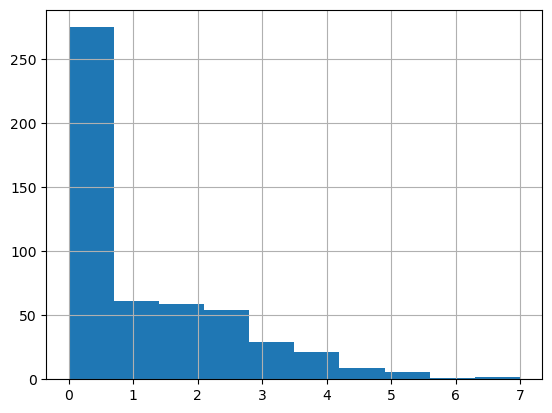

In [4]:
fires["log_area"] = np.log(fires["area"] + 1)
fires["log_area"].hist()                             

The result is still right-skewed, but less so. The `log_area` would be a better alternative to `area` for using in the Regression model.

In [5]:
fires["month"].value_counts(normalize=True)

aug    0.355899
sep    0.332689
mar    0.104449
jul    0.061896
feb    0.038685
jun    0.032882
oct    0.029014
apr    0.017408
dec    0.017408
jan    0.003868
may    0.003868
nov    0.001934
Name: month, dtype: float64

Month seems to be a valuable column. However I cannot use string values in the model. Also I cannot replace with the month numbers as the model will scale with the larger numbers. So instead I will create a new column indicating if the month is during summer.

In [6]:
summer = ["jul", "aug", "sep"]
fires["summer"] = fires["month"].apply(lambda x: 1 if x in summer else 0)
fires.head()

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area,summer
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0,0.0,0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0,0.0,0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0,0.0,0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0,0.0,0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0,0.0,0


I will use K-nearest neighbours to fill in the null values in the data. This works by imputing the average from only similar observations rather than the whole column.

In [7]:
from sklearn.impute import KNNImputer

imp = KNNImputer(missing_values = np.nan, n_neighbors=3)

fires_missing = fires[fires.columns[5:13]] # FFMC to rain
imputed = pd.DataFrame(imp.fit_transform(fires_missing), 
                       columns = fires.columns[5:13])
imputed

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,86.2,26.200000,94.300000,5.1,16.6,51.0,6.700000,0.0
1,90.6,56.433333,669.100000,6.7,18.0,33.0,0.900000,0.0
2,90.6,43.700000,470.833333,6.7,14.6,33.0,1.300000,0.0
3,91.7,33.300000,77.500000,9.0,8.3,97.0,4.000000,0.2
4,89.3,51.300000,102.200000,9.6,11.4,99.0,4.333333,0.0
...,...,...,...,...,...,...,...,...
512,81.6,56.700000,665.600000,1.9,27.8,32.0,2.700000,0.0
513,81.6,56.700000,665.600000,1.9,21.9,71.0,5.800000,0.0
514,81.6,56.700000,665.600000,1.9,21.2,70.0,6.700000,0.0
515,94.4,146.000000,614.700000,11.3,25.6,42.0,4.000000,0.0


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(imputed)
scaled = pd.DataFrame(scaled, columns = fires.columns[5:13])

final = pd.concat([fires["summer"], scaled], axis=1)

final

,summer,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,0,-0.812283,-1.335942,-1.846711,-0.860187,-0.398187,0.418726,1.514159,-0.073268
1,0,-0.010735,-0.859009,0.509582,-0.508736,-0.155493,-0.715565,-1.761003,-0.073268
2,0,-0.010735,-1.059878,-0.303178,-0.508736,-0.744894,-0.715565,-1.535130,-0.073268
3,0,0.189652,-1.223939,-1.915580,-0.003526,-1.837021,3.317471,-0.010485,0.603155
4,0,-0.247556,-0.939988,-1.814327,0.128267,-1.299625,3.443503,0.177742,-0.073268
...,...,...,...,...,...,...,...,...,...
512,1,-1.650265,-0.854803,0.495235,-1.563087,1.543370,-0.778581,-0.744573,-0.073268
513,1,-1.650265,-0.854803,0.495235,-1.563087,0.520585,1.679050,1.005944,-0.073268
514,1,-1.650265,-0.854803,0.495235,-1.563087,0.399238,1.616034,1.514159,-0.073268
515,1,0.681511,0.553912,0.286579,0.501683,1.161993,-0.148419,-0.010485,-0.073268


## Data Visualisation

I will now visualise the relationships between the feature columns and log-area

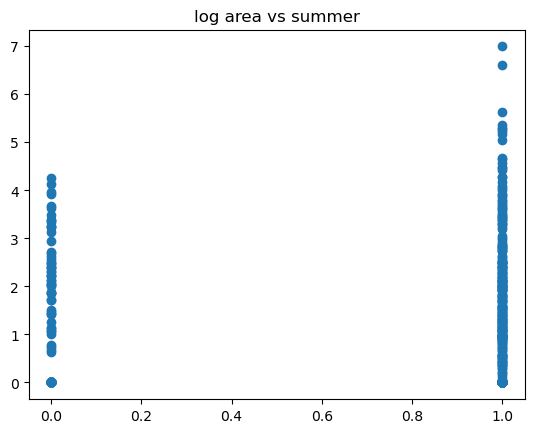

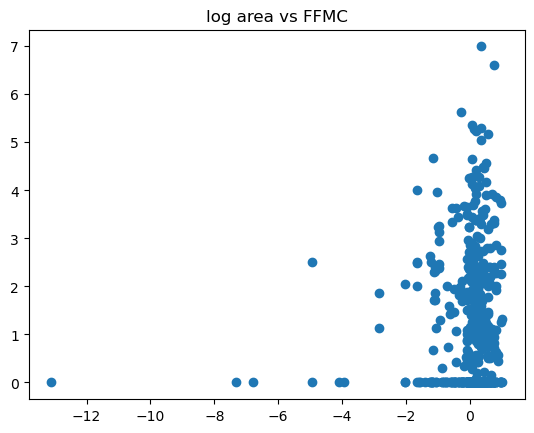

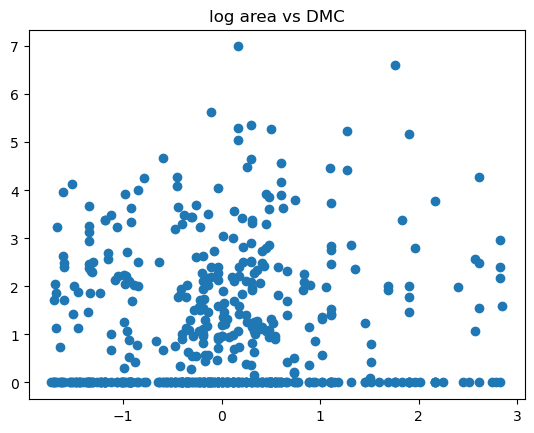

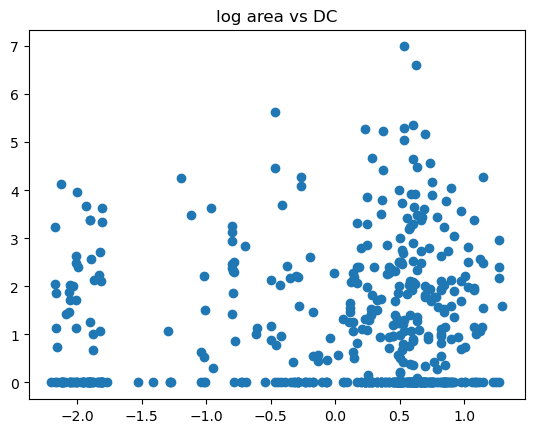

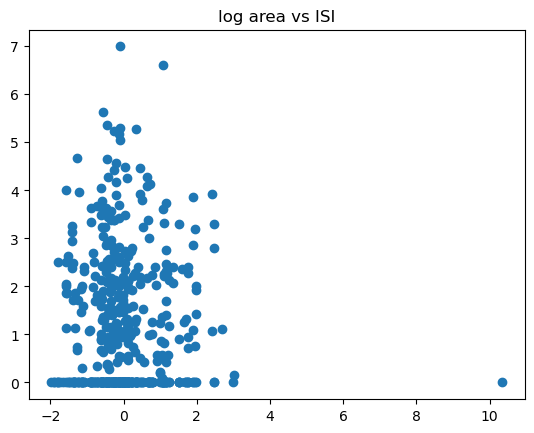

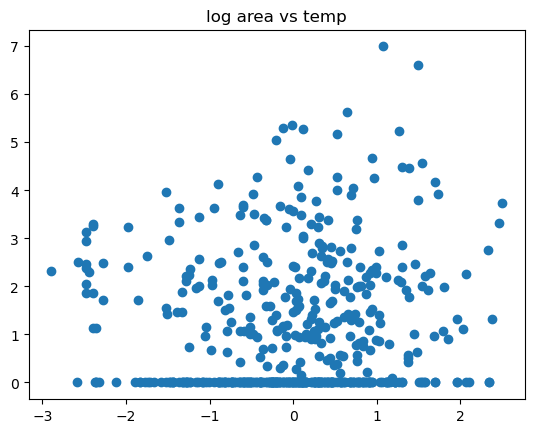

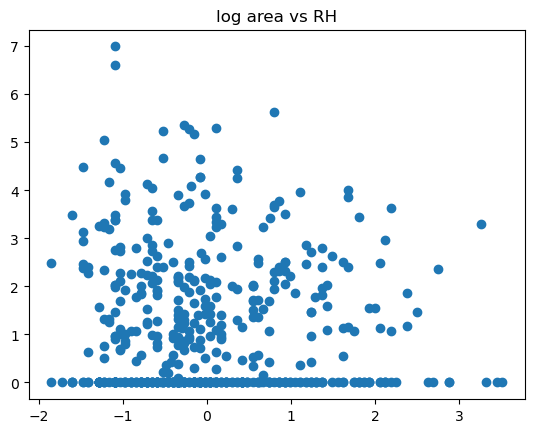

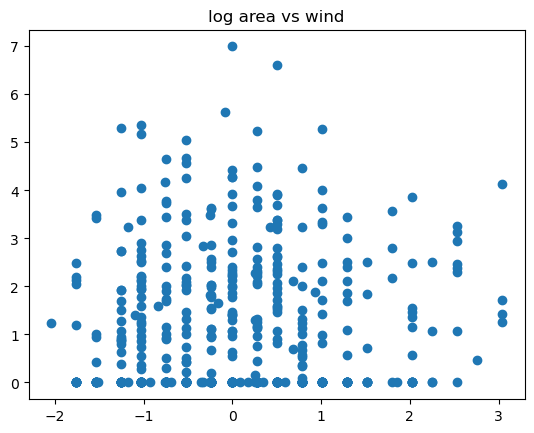

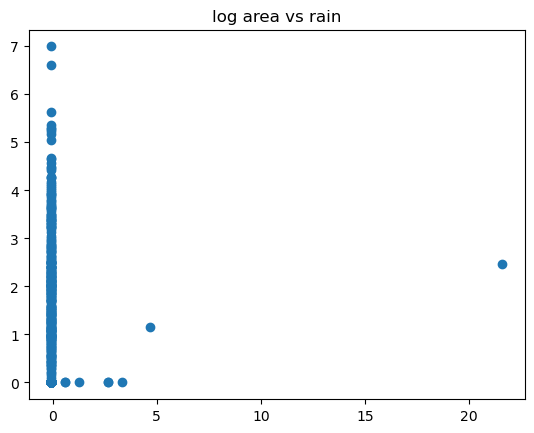

In [9]:
import matplotlib.pyplot as plt

for col in final.columns:
    plt.scatter(final[col], fires["log_area"])
    plt.title("log area vs " + col)
    plt.show()

At this stage it is difficult to see a strong correlation between log_area and any of the features

## Subset Selection

I will now use sequential feature selection to select the best features to use in the model. I will dtermine whether 2, 4 or 6 features are best. I will use both forward and backward feature selection. Forward starts with the intercept only and adds one feature at a time, backward starts with a full model and removes one feature at a time.

In [10]:
from sklearn.feature_selection import SequentialFeatureSelector

y = fires["log_area"]

model = LinearRegression()
model2 = LinearRegression()
model3 = LinearRegression()

forwards2 = SequentialFeatureSelector(estimator=model,
                                      n_features_to_select=2,
                                      direction="forward")
forwards4 = SequentialFeatureSelector(estimator=model2,
                                      n_features_to_select=4,
                                      direction="forward")
forwards6 = SequentialFeatureSelector(estimator=model3,
                                      n_features_to_select=6,
                                      direction="forward")

forwards2.fit(final,y)
forwards4.fit(final,y)
forwards6.fit(final,y)

print("Features selected in 2 feature forward model:",forwards2.get_feature_names_out())
print("Features selected in 4 feature forward model:",forwards4.get_feature_names_out())
print("Features selected in 6 feature forward model:",forwards6.get_feature_names_out())

Features selected in 2 feature forward model: ['FFMC' 'DC']
Features selected in 4 feature forward model: ['summer' 'FFMC' 'DC' 'wind']
Features selected in 6 feature forward model: ['summer' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


In [11]:
model4 = LinearRegression()
model5 = LinearRegression()
model6 = LinearRegression()

backwards2 = SequentialFeatureSelector(estimator=model4,
                                      n_features_to_select=2,
                                      direction="backward")
backwards4 = SequentialFeatureSelector(estimator=model5,
                                      n_features_to_select=4,
                                      direction="backward")
backwards6 = SequentialFeatureSelector(estimator=model6,
                                      n_features_to_select=6,
                                      direction="backward")

backwards2.fit(final,y)
backwards4.fit(final,y)
backwards6.fit(final,y)

print("Features selected in 2 feature backwards model:",backwards2.get_feature_names_out())
print("Features selected in 4 feature backwards model:",backwards4.get_feature_names_out())
print("Features selected in 6 feature backwards model:",backwards6.get_feature_names_out())

Features selected in 2 feature backwards model: ['FFMC' 'DC']
Features selected in 4 feature backwards model: ['summer' 'FFMC' 'DC' 'wind']
Features selected in 6 feature backwards model: ['summer' 'FFMC' 'DC' 'ISI' 'RH' 'wind']


The sequential feature selector has shown `FFMC` and `DC` are most impactful on `log_area`. `Summer` and `wind` next most impactful. `ISI` and `RH` are the least impactful.

## Developing Candidate Models

I will use LASSO and Ridge regularisation techniques to try and improve performance.

In [12]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(alphas = np.linspace(1, 10000, num=1000))
lasso = LassoCV(alphas = np.linspace(1, 10000, num=1000))

ridge.fit(final, y)
lasso.fit(final, y)

print("Ridge tuning parameter: ", ridge.alpha_)
print("LASSO tuning parameter: ", lasso.alpha_)

print("Ridge coefficients: ", ridge.coef_)
print("LASSO coefficients: ", lasso.coef_)

Ridge tuning parameter:  2333.099099099099
LASSO tuning parameter:  10000.0
Ridge coefficients:  [ 0.00405878  0.00926936  0.01339043  0.01374212 -0.00608443  0.00906039
 -0.01023297  0.01711038  0.00548142]
LASSO coefficients:  [ 0.  0.  0.  0. -0.  0. -0.  0.  0.]


LASSO appears to be unaffective, however Ridge might be worth assessing further.

I am also going to perform and polynomial and spline transformation on the data to determine if a non-linear relationship would fit better.

In [13]:
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer

poly = PolynomialFeatures(degree=3)
poly_X = poly.fit_transform(final)

spline = SplineTransformer(degree=3, n_knots=2, knots="uniform")
spline_X = spline.fit_transform(final)

## K-Fold Cross Validation

I will use K-Fold Cross Validation to fold (split) the data multiple times and assess the model's performance on each split. I will be testing 10 models in total: a reference model, the 6 sequential models, the ridge model, the polynomial model and the spline model.

In [14]:
ref = LinearRegression()

fw2_model = LinearRegression() 
fw4_model = LinearRegression() 
fw6_model = LinearRegression() 

bw2_model = LinearRegression() 
bw4_model = LinearRegression()
bw6_model = LinearRegression() 

poly_model = LinearRegression()
spline_model = LinearRegression()


from sklearn.model_selection import cross_val_score 

reference_cv = cross_val_score(ref, final[["wind", "temp"]], y, cv = 5, scoring = "neg_mean_squared_error")
fw2_cv = cross_val_score(fw2_model, final[forwards2.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
fw4_cv = cross_val_score(fw4_model, final[forwards4.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
fw6_cv = cross_val_score(fw6_model, final[forwards6.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw2_cv = cross_val_score(bw2_model, final[backwards2.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw4_cv = cross_val_score(bw4_model, final[backwards4.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw6_cv = cross_val_score(bw6_model, final[backwards6.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
ridge_cv = cross_val_score(ridge, final, y, cv = 5, scoring = "neg_mean_squared_error")
poly_cv = cross_val_score(poly_model, poly_X, y, cv = 5, scoring = "neg_mean_squared_error")
spline_cv = cross_val_score(spline_model, spline_X, y, cv = 5, scoring = "neg_mean_squared_error")

In [15]:
print("Reference Model, Avg Test MSE: ", np.mean(reference_cv), " SD: ", np.std(reference_cv))
print("Forward-2 Model, Avg Test MSE: ", np.mean(fw2_cv), " SD: ", np.std(fw2_cv))
print("Forward-4 Model, Avg Test MSE: ", np.mean(fw4_cv), " SD: ", np.std(fw4_cv))
print("Forward-6 Model, Avg Test MSE: ", np.mean(fw6_cv), " SD: ", np.std(fw6_cv))
print("Backward-2 Model, Avg Test MSE: ", np.mean(bw2_cv), " SD: ", np.std(bw2_cv))
print("Backward-4 Model, Avg Test MSE: ", np.mean(bw4_cv), " SD: ", np.std(bw4_cv))
print("Backward-6 Model, Avg Test MSE: ", np.mean(bw6_cv), " SD: ", np.std(bw6_cv))
print("Ridge Model, Avg Test MSE: ", np.mean(bw6_cv), " SD: ", np.std(bw6_cv))
print("Polynomial Model, Avg Test MSE: ", np.mean(poly_cv), " SD: ", np.std(poly_cv))
print("Spline Model, Avg Test MSE: ", np.mean(spline_cv), " SD: ", np.std(spline_cv))

Reference Model, Avg Test MSE:  -2.204650013004116  SD:  1.060040355378637
Forward-2 Model, Avg Test MSE:  -2.1735431721198535  SD:  1.0208083278697588
Forward-4 Model, Avg Test MSE:  -2.174615917699114  SD:  1.002985547658543
Forward-6 Model, Avg Test MSE:  -2.201074055258934  SD:  0.994037960379732
Backward-2 Model, Avg Test MSE:  -2.1735431721198535  SD:  1.0208083278697588
Backward-4 Model, Avg Test MSE:  -2.174615917699114  SD:  1.002985547658543
Backward-6 Model, Avg Test MSE:  -2.201074055258934  SD:  0.994037960379732
Ridge Model, Avg Test MSE:  -2.201074055258934  SD:  0.994037960379732
Polynomial Model, Avg Test MSE:  -20456.005274874606  SD:  36529.075197374295
Spline Model, Avg Test MSE:  -4.922771381094122e+20  SD:  9.845542762188244e+20


The two feature Linear model without regularisation seems to perform best with an average MSE of -2.1735

## Examining Model Weakness

I will now make predictions using the best performing model and examine how well they perform.

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(final[forwards2.get_feature_names_out()], y, test_size=0.2, random_state=303)

fw2_model.fit(X_train, y_train)

predictions = fw2_model.predict(X_test)
residuals = y_test - predictions

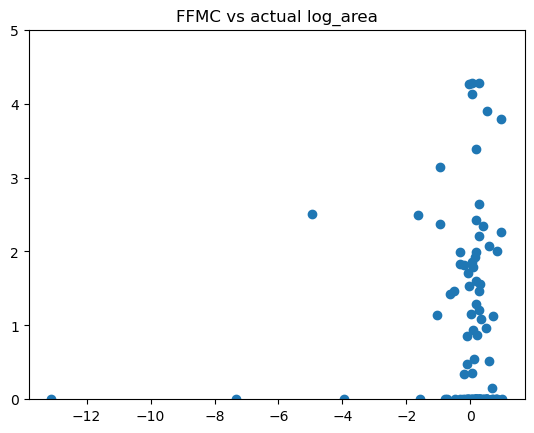

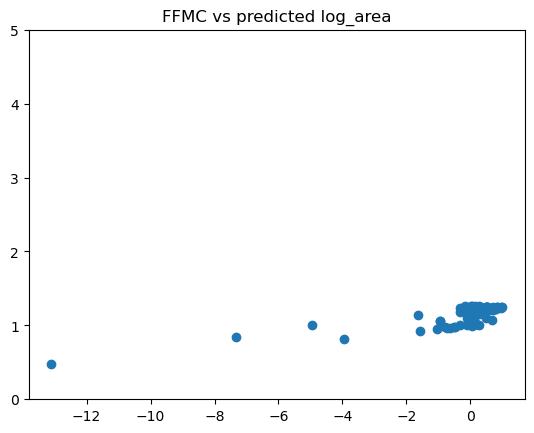

In [17]:
plt.scatter(X_test["FFMC"], y_test)
plt.title("FFMC vs actual log_area")
plt.ylim(0,5)
plt.show()
plt.scatter(X_test["FFMC"], predictions)
plt.title("FFMC vs predicted log_area")
plt.ylim(0,5)
plt.show()

The above charts show the comparison of FFMC against the actual log_area and the predicted log_area. It shows the model underestimates log_area when FFMC approaches 0.

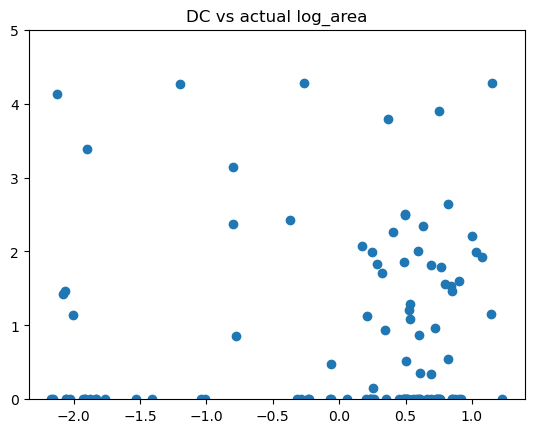

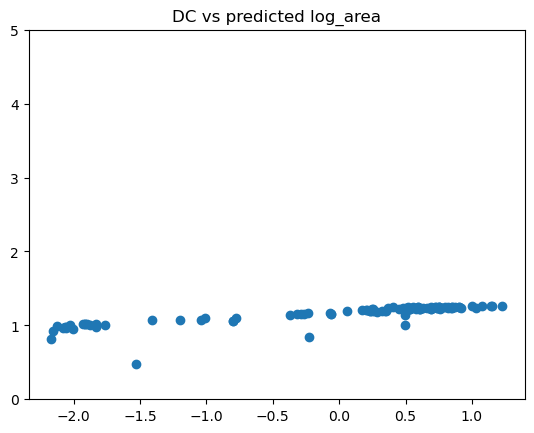

In [18]:
plt.scatter(X_test["DC"], y_test)
plt.title("DC vs actual log_area")
plt.ylim(0,5)
plt.show()
plt.scatter(X_test["DC"], predictions)
plt.title("DC vs predicted log_area")
plt.ylim(0,5)
plt.show()

The above shows the difference between the acutal and predicted log_area when compared with DC.

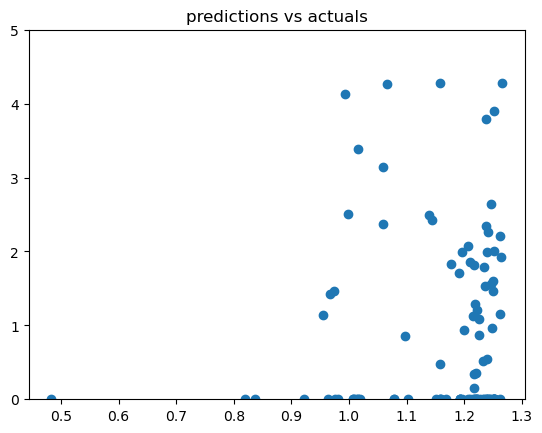

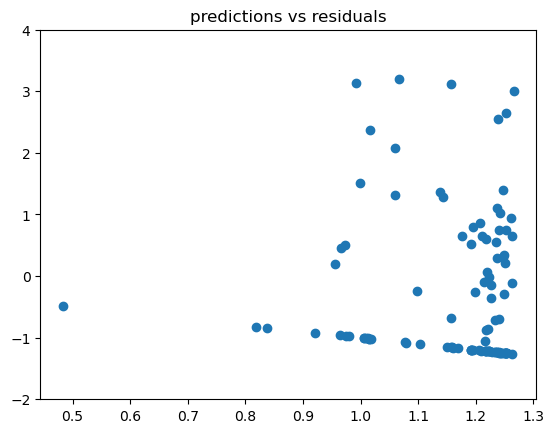

In [19]:
plt.scatter(predictions, y_test)
plt.title("predictions vs actuals")
plt.ylim(0,5)
plt.show()
plt.scatter(predictions, residuals)
plt.title("predictions vs residuals")
plt.ylim(-2,4)
plt.show()

The two above charts highlight the differerences between the actual log_area values and the predicted log_area values.  
For a prefectly performing model, actual vs predictions should be a straight 45 degree line and predictions vs residuals should be a horizontal line at 0 on the y-axis.  
These two charts show the poor performance of the model, especially when log_area is larger. It rarely overestimates, but frequently under estimates. Some of the under estimations are so severe that this model would unlikely be able to be of any use.  

This shows that due to the extreme right-skew of the data a Linear Regression model is unable to effectively make predictions. 